![](./images/07_01.jpg)

In [1]:
%load_ext autoreload
%autoreload 2

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
from modules.my_pyspark import *
from modules.my_spark_linear_regression import *

In [3]:
data_path = r"./data/cruise_ship_info.csv"

In [4]:
spark = MyPySpark(session=True)

# 1. Đọc dữ liệu

In [5]:
df = spark.readFile(data_path, 'csv')

In [6]:
df.describe().toPandas()

,summary,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew
0,count,158,158,158,158,158,158,158,158,158
1,mean,Infinity,None,15.689873417721518,71.28467088607599,18.45740506329114,8.130632911392404,8.830000000000005,39.90094936708861,7.794177215189873
2,stddev,None,None,7.615691058751413,37.229540025907866,9.677094775143416,1.793473548054825,4.4714172221480615,8.63921711391542,3.503486564627034
3,min,Adventure,Azamara,4,2.329,0.66,2.79,0.33,17.7,0.59
4,max,Zuiderdam,Windstar,48,220.0,54.0,11.82,27.0,71.43,21.0


In [7]:
df.count()

158

In [8]:
df.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [9]:
df.show(5, False)

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|Ship_name  |Cruise_line|Age|Tonnage           |passengers|length|cabins|passenger_density|crew|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|Journey    |Azamara    |6  |30.276999999999997|6.94      |5.94  |3.55  |42.64            |3.55|
|Quest      |Azamara    |6  |30.276999999999997|6.94      |5.94  |3.55  |42.64            |3.55|
|Celebration|Carnival   |26 |47.262            |14.86     |7.22  |7.43  |31.8             |6.7 |
|Conquest   |Carnival   |11 |110.0             |29.74     |9.53  |14.88 |36.99            |19.1|
|Destiny    |Carnival   |17 |101.353           |26.42     |8.92  |13.21 |38.36            |10.0|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
only showing top 5 rows



> **Nhận xét**:
> * Predictor variables: `Cruise_line`, `Age`, `Tonnage`, `passengers`, `length`, `cabins`, `passenger_density`
> * Target variable: `crew`

# 2. Chuẩn hóa dữ liệu

In [10]:
from modules.my_spark_preprocessing import indexerData

* Áp dụng StringIndexer cho feature `Cruise_line`

In [11]:
df_indexer = indexerData(df, ['Cruise_line'])

In [12]:
df_indexer.head(5)

[Row(Ship_name='Journey', Cruise_line='Azamara', Age=6, Tonnage=30.276999999999997, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, crew=3.55, idx_Cruise_line=16.0),
 Row(Ship_name='Quest', Cruise_line='Azamara', Age=6, Tonnage=30.276999999999997, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, crew=3.55, idx_Cruise_line=16.0),
 Row(Ship_name='Celebration', Cruise_line='Carnival', Age=26, Tonnage=47.262, passengers=14.86, length=7.22, cabins=7.43, passenger_density=31.8, crew=6.7, idx_Cruise_line=1.0),
 Row(Ship_name='Conquest', Cruise_line='Carnival', Age=11, Tonnage=110.0, passengers=29.74, length=9.53, cabins=14.88, passenger_density=36.99, crew=19.1, idx_Cruise_line=1.0),
 Row(Ship_name='Destiny', Cruise_line='Carnival', Age=17, Tonnage=101.353, passengers=26.42, length=8.92, cabins=13.21, passenger_density=38.36, crew=10.0, idx_Cruise_line=1.0)]

# 3. Chuyển đổi dữ liệu

In [13]:
from modules.my_spark_linear_regression import *

In [14]:
predictor_features = ['idx_Cruise_line', 'Age', 'Tonnage', 'passengers', 'length', 'cabins', 'passenger_density']
target_feature = 'crew'

In [15]:
lr_model = MySparkLinearRegression(df_indexer, predictor_features, target_feature)

In [16]:
lr_model.prepareData()

In [17]:
lr_model.df_data.show(5, False)

+--------------------------------------------------+----+
|features                                          |crew|
+--------------------------------------------------+----+
|[16.0,6.0,30.276999999999997,6.94,5.94,3.55,42.64]|3.55|
|[16.0,6.0,30.276999999999997,6.94,5.94,3.55,42.64]|3.55|
|[1.0,26.0,47.262,14.86,7.22,7.43,31.8]            |6.7 |
|[1.0,11.0,110.0,29.74,9.53,14.88,36.99]           |19.1|
|[1.0,17.0,101.353,26.42,8.92,13.21,38.36]         |10.0|
+--------------------------------------------------+----+
only showing top 5 rows



# 4. Chia dữ liệu thành training data và test data

In [18]:
lr_model.trainTestSplit()

In [19]:
lr_model.describeTarget()

+-------+-----------------+-----------------+
|summary|     crew (train)|      crew (test)|
+-------+-----------------+-----------------+
|  count|              108|               50|
|   mean|7.601388888888893|           8.2106|
| stddev|3.303965744638486|3.902816570590202|
|    min|             0.59|             0.59|
|    max|             19.1|             21.0|
+-------+-----------------+-----------------+



> **Nhận xét**
> * Thống kê mô tả trên hai tập training data và test data tốt

# 5. Build Model 

In [20]:
lr_model.buildModel()

In [21]:
lr_model.coefficients

array([ 0.05033244, -0.01234149,  0.0271894 , -0.17178501,  0.29343451,
        0.82746916, -0.00757564])

In [22]:
lr_model.intercept

-0.3532042819923151

# 6. Đánh giá model

In [23]:
metric, residual = lr_model.evaluate()

In [24]:
metric

,Metric,Value
0,MAE,0.661963
1,MSE,0.625823
2,RMSE,0.791090
3,R-SQUARED,0.958075


> **Nhận xét**
> * Model cho ra kết quả đánh giá tốt.

In [25]:
residual.describe().show()

+-------+--------------------+
|summary|           residuals|
+-------+--------------------+
|  count|                  50|
|   mean|-0.22561575769517797|
| stddev|  0.7659333628470786|
|    min| -2.0572754576603085|
|    max|  0.9338715809046549|
+-------+--------------------+



> **Nhận xét**
> * Phần dư nhỏ, ko cao.

* Trực quan hóa xem giữa dự đoán và giá trị thực tế có chênh nhau lớn ko

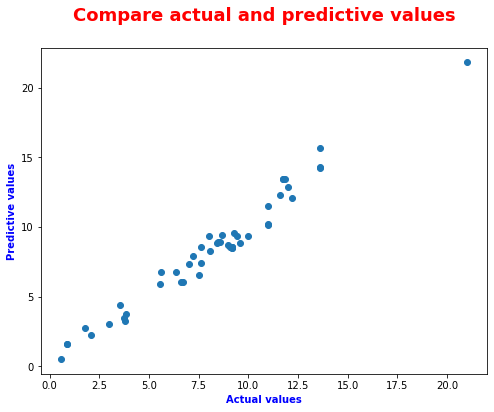

In [26]:
test_predict = lr_model.evaluateTestData(True)

> **Nhận xét**
> * Giữa thực tế và dự đoán ko chênh nhau nhiều

In [27]:
test_predict.show(truncate=False)

+----------------------------------------+-----+------------------+
|features                                |crew |predict_crew      |
+----------------------------------------+-----+------------------+
|[0.0,4.0,220.0,54.0,11.82,27.0,40.74]   |21.0 |21.80413810263026 |
|[0.0,5.0,160.0,36.34,11.12,18.17,44.03] |13.6 |15.657275457660308|
|[0.0,6.0,158.0,43.7,11.25,18.0,36.16]   |13.6 |14.283314478847638|
|[0.0,7.0,158.0,43.7,11.12,18.0,36.16]   |13.6 |14.23282650571903 |
|[0.0,10.0,90.09,25.01,9.62,10.5,36.02]  |8.58 |8.914922132484973 |
|[0.0,10.0,138.0,31.14,10.2,15.57,44.32] |11.85|13.467106863771189|
|[0.0,11.0,90.09,25.01,9.62,10.5,36.02]  |8.48 |8.902580645785896 |
|[0.0,13.0,138.0,31.14,10.2,15.57,44.32] |11.76|13.430082403673959|
|[0.0,14.0,138.0,31.14,10.2,15.57,44.32] |11.76|13.417740916974882|
|[0.0,17.0,74.137,19.5,9.16,9.75,38.02]  |7.6  |8.570581681027916 |
|[0.0,18.0,70.0,18.0,8.67,9.0,38.89]     |7.2  |7.932459594841203 |
|[0.0,25.0,73.192,28.52,8.8,11.38,25.66] |8.08 |